# Training A Neural Netowrk Using PyTorch and My Custom Libraries
This notebook will go through and explain the steps involved in creating a NN model and training it given some dataset

## Composer Pattern
Model training is set-up using the composer pattern. Where, you create different components and compose them onto a ModelTrainer, which ultimately takes care of the training/validation process. 
![Pics](./composer.png)


## Setting GPU
The first step for systems with multiple GPUs is to set which one we want to use. In torch, this is done by changing the environment varaible **CUDA_VISIBLE_DEVICES**. This makes cuda only 'see' that one specific GPU. i.e., all data will be loaded to that GPU. Pytorch will then regard this GPU as 'cuda:0'

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Defining a Dataset
Let's define a random dataset. Most of our data is stored as pandas dataframes. I have convinience functions that can convert these DataFrames onto Pytorch DataLoaders. Which, as the name suggests, fetches data during model training. However, you can also manually define your own DataLoader classes to use some other types of data if need be.

In [2]:
import pandas as pd
from inverse_modelling_tfo.model_training.DataLoaderGenerators import DataLoaderGenerator
from inverse_modelling_tfo.model_training.validation_methods import RandomSplit

dummy_data = pd.DataFrame({
        'A': [1, 2, 3, 4, 5],
        'B': [2, 3, 4, 5, 6],
        'C': [3, 5, 7, 9, 11]})
data_loader_params = {
    'shuffle': True,    # The dataloader will shuffle its outputs at each epoch
    'num_workers': 0,   # The number of workers that the dataloader will use to generate the batches
}
dataloader_gen = DataLoaderGenerator(dummy_data, ['A', 'B'], ['C'], 2, data_loader_params)
validation_method = RandomSplit(0.5)
train_loader, validation_loader = dataloader_gen.generate(validation_method)
print("The output type is", type(train_loader))

The output type is <class 'torch.utils.data.dataloader.DataLoader'>


__Notes__: The data generated from these loaders are by default set to be stored on CUDA. More specifically, the first GPU on CUDA. You can change the device parameter on DataLoaderGenerator to change this behavior.

## Validation Method
One thing that I didn't explain in the last step is the validation method. You can pass different validation strategies to alter the training/validation data loader behavior. For example, here we are using a RandomSplit(0.8). But, we have a few more options.

In [3]:
from inverse_modelling_tfo.model_training.validation_methods import RandomSplit, HoldOneOut, CVSplit, CombineMethods

train_loader, validation_loader = dataloader_gen.generate(CVSplit(2, 0))

This is a Cross-Validation split. It will split the data into 2 parts and uses the first(0th index) part as the validation set  
For more usage example, check the test/test_data/test_validation_split.py file! 

## Loss Function
The next component we need for training a model is a LossFunction. I have a custom wrapper around pytorch's native loss functions. The benefits of this are two-fold. This wrapper allows us to track the losses over each step and each epoch of the training. Making for a far easier loss tracking/plotting expreience. Additionally, this extends the loss function to include more exotic losses which can take extra inputs(other than model labels and preidctions). This includes physics losses.  

In [4]:
from inverse_modelling_tfo.model_training import TorchLossWrapper
import torch.nn as nn   # PyTorch's neural network module

criterion = TorchLossWrapper(nn.MSELoss(), name="mse")   # good old MSE loss

## Model Architecture
Now, its time to define the neural network model. Defining models in pytorch is quite a bit of a chore. Where, you need to define each layer individually and then define how the data flows through it. While, yes it allows for great level of flexibility, its also very time consuming. I have a set of very simple models defined, which can be very quickly modified with simple parameters. This allows for much faster testing and tuning. 


The model example we use here is a fully connected perceptron with BatchNormalization and Dropout layers, called PerceptronBD. The 'node_counts' here specifies the number of 'nodes' on each layer of the perceptron. So for example, node_counts = [2, 2, 1] stands for, 3 input nodes, 2 nodes in the hidden layer and single output node. Note that except for the final layer, every other layer has a ReLU non-linear activation function.

I have few more models inside the model_training/custom_models.py file. If needed, you can extend that to include fancier architectures.

In [5]:
from inverse_modelling_tfo.model_training.custom_models import PerceptronBD

model = PerceptronBD([2, 2, 1], dropout_rates=[0.5, 0.5]) 
# With a node_count length of 3, we actually get 2 layers. Which is why dropout_rates has a length of 2. 

In [6]:
# We can visualize this model by using torchinfo
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       6
│    └─BatchNorm1d: 2-2                  4
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       3
│    └─Flatten: 2-6                      --
Total params: 13
Trainable params: 13
Non-trainable params: 0

```
Breakdown:      
    Sequential -> Data passes through a set of sequential layers        
    Linear -> FC linear layer       
    BatchNorm & Dropout -> No brainer. Also, BatchNorm layer **MUST** be placed before dropout. There are a bunch of important papers explaining why this   is the case     
    ReLu -> Non-linearity       
    Flatten -> does not do anything other than changing the data dimensionality.        
```

## ModelTrainer
It's finally time to compose the model trainer! This is what I use to run the training loop. Now, pytorch by default does not have any trainer class. But rather expects you to always manually write your own training loop. Which, if you're doing it a bunch of times, is quite time consuming. 

In [7]:
from inverse_modelling_tfo.model_training import ModelTrainer 

trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)
trainer.run(10)

## Tuning The Optimizer
The model trainer is compiled with a default SGD optimizer. Which might not always be the best fit for the job. Often times you would need to tune the optimizer to get the best results. There are actually two different ways to tune the optimizer.      
1. Changing the batch_size. This is actually the more preferable option and tends to give better gains
2. Using a different optimizer/changing the optimizer parameters. This is usually better fine tuning.

In [8]:
from torch.optim import SGD
trainer.change_batch_size(4)        # option 1
trainer.set_optimizer(SGD, {'lr': 1e-4, 'momentum': 0.91, 'weight_decay': 1e-4})    # option 2
trainer.run(10)

## Plotting the Results
Usually, we are concerned about the training and validation loss. The LossFunction we defined earlier gives us access to the loss per epoch and can easily be plotted using it's underlying loss_tracker object.

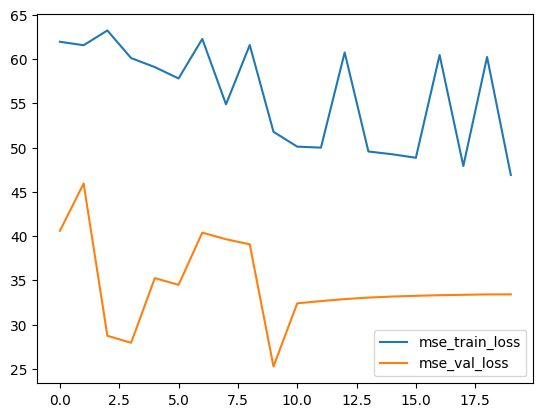

In [9]:
criterion.loss_tracker.plot_losses()    # Plot the losses

__Note__: The loss tracker keeps record of all the model trainer runs. Which might not always be desirable. But you can reset the loss at any point to clear out old data.

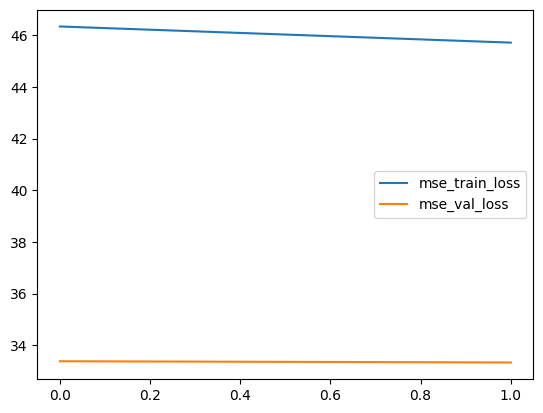

In [10]:
import matplotlib.pyplot as plt

loss_plot = plt.figure()
criterion.reset()
trainer.run(2)
criterion.loss_tracker.plot_losses()    # Plot the refreshed losses

# Reporting & Reproducibility
There are also a few options to help with reporting and reproducibility.
1. The model trainer has a string representation which details each of the components it is composed off. This can be stored and retrived later to redo the experiment. 
2. Markdown Report : Refer to this [github repo](https://github.com/RishadR/mdreport). This allows you to write a short report in jupyter notebook and save the experiment parameters,results,figures etc. as a markdown file(which can also be converted to a pdf if needed)
3. Seeds: For the many componets that rely on randomness, it makes sense to set a specific seed

### ModelTrainer String

In [11]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0.91
    nesterov: False
    weight_decay: 0.0001
)
        DataLoader Params: 
            Batch Size: 4
            Validation Method: Split the data randomly using np.random.shuffle with a split of 0.5
        Loss:
            Train Loss: 45.71092987060547
            Val. Loss: 33.33828353881836


### Markdown Report Example

In [12]:
from mdreport import MarkdownReport
from pathlib import Path

report = MarkdownReport(Path('results'), 'report1', 'Example Report')
report.add_text_report("Objective", "Training Models using the ModelTrainer Class")
report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
report.add_image_report("Loss Curves", loss_plot)
report.save_report()


### Seeds

In [13]:
from inverse_modelling_tfo.misc import set_seed
# Control the randomness
set_seed(42)
model = PerceptronBD([2, 2, 1], dropout_rates=[0.5, 0.5])